## Test to Report

In [4]:
# %% Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path

# paths
CSV_REPORT = Path("Testreport_timeseries.csv")
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# output files
OUT_PNG_MONTHLY       = OUT_DIR / "test_to_report_monthly_avg.png"
OUT_CSV_MONTHLY       = OUT_DIR / "test_to_report_monthly_averages.csv"
OUT_PNG_REGION        = OUT_DIR / "test_to_report_region_names_avg.png"
OUT_CSV_REGION        = OUT_DIR / "test_to_report_region_names_avg.csv"
OUT_PNG_MONTHLY_TYPES = OUT_DIR / "test_to_report_monthly_nhs_vs_private.png"
OUT_PNG_YEARLY_TYPES  = OUT_DIR / "test_to_report_yearly_nhs_vs_private.png"
OUT_CSV_YEARLY        = OUT_DIR / "test_to_report_yearly_averages.csv"


In [5]:
# %% Load and standardize
df = pd.read_csv(CSV_REPORT)
df.columns = (
    df.columns
      .astype(str)          # ensure all names are strings
      .str.strip()          # remove leading/trailing spaces
      .str.replace(" ", "_")
      .str.lower()
)


# keep a working copy
rep = df.copy()


In [6]:
# %% Detect provider column and classify NHS vs Private
common_provider_cols = ["provider_name","provider","trust","organisation","organization","org_name"]
prov_col = next((c for c in rep.columns if c in common_provider_cols), None)
if prov_col is None:
    prov_col = next((c for c in rep.columns if "provider" in c), None)
if prov_col is None:
    raise ValueError("Could not find a provider column.")

nhs_pattern = re.compile(r"\bnhs\b|national\s+health(\s+service)?", re.IGNORECASE)

def classify_provider(name) -> str:
    if pd.isna(name):
        return "Unknown"
    return "NHS" if nhs_pattern.search(str(name)) else "Private"

rep["provider_type"] = rep[prov_col].apply(classify_provider)


In [7]:
# %% Detect and parse date column
date_candidates = [c for c in rep.columns if "date" in c]
if not date_candidates:
    # try a robust fallback if no explicit date column name
    best_col = None
    best_cov = -1.0
    for c in rep.columns:
        if pd.api.types.is_numeric_dtype(rep[c]):
            continue
        parsed = pd.to_datetime(rep[c], errors="coerce", dayfirst=True)
        cov = parsed.notna().mean()
        if cov > best_cov and parsed.nunique(dropna=True) >= 3:
            best_cov = cov
            best_col = c
    if best_col is None:
        raise ValueError("Could not detect a date column.")
    date_col = best_col
else:
    # pick the best-parsing date-like column
    best_col = None
    best_cov = -1.0
    for c in date_candidates:
        parsed = pd.to_datetime(rep[c], errors="coerce", dayfirst=True)
        cov = parsed.notna().mean()
        if cov > best_cov and parsed.nunique(dropna=True) >= 3:
            best_cov = cov
            best_col = c
    date_col = best_col

rep[date_col] = pd.to_datetime(rep[date_col], errors="coerce", dayfirst=True)


C:\Users\PAVILION\AppData\Local\Temp\ipykernel_32520\1685612391.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(rep[c], errors="coerce", dayfirst=True)
C:\Users\PAVILION\AppData\Local\Temp\ipykernel_32520\1685612391.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rep[date_col] = pd.to_datetime(rep[date_col], errors="coerce", dayfirst=True)


In [8]:
# %% Detect value column (median days for test -> report) and clean
# prefer names containing "median", "report" and "day"
def score_value_col(name: str, s: pd.Series) -> float:
    n = name.lower()
    score = 0.0
    if "median" in n: score += 2
    if "report" in n: score += 2
    if "day" in n or "days" in n: score += 1
    score += min(s.nunique(dropna=True), 5) * 0.1
    return score

numeric_like = {}
for c in rep.columns:
    if c in {date_col, "provider_type"}:
        continue
    # clean obvious non-numeric cruft before coercion
    s = rep[c].astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().mean() > 0.6:
        numeric_like[c] = s

if not numeric_like:
    raise ValueError("No numeric-like columns found for the metric.")

val_col = max(numeric_like.keys(), key=lambda c: score_value_col(c, numeric_like[c]))
rep[val_col] = numeric_like[val_col]


In [9]:
# %% Optional: filter by specific codes (leave lists empty to skip)
# Examples:
# filter by region code or name, or provider codes/names as needed
region_code_col = next((c for c in rep.columns if c in ["region","region_code","nhs_region_code"]), None)
region_name_col = next((c for c in rep.columns if c in ["regionname","region_name","region_full_name","region_full"]), None)
org_code_col    = next((c for c in rep.columns if c in ["org_code","organisation_code","organization_code","provider_code"]), None)

REGION_CODES  = []   # e.g., ["R1","R2"]
REGION_NAMES  = []   # e.g., ["London","Midlands"]
ORG_CODES     = []   # e.g., ["ABC01","XYZ02"]

mask = pd.Series(True, index=rep.index)
if REGION_CODES and region_code_col:
    mask &= rep[region_code_col].astype(str).isin([str(x) for x in REGION_CODES])
if REGION_NAMES and region_name_col:
    mask &= rep[region_name_col].astype(str).isin([str(x) for x in REGION_NAMES])
if ORG_CODES and org_code_col:
    mask &= rep[org_code_col].astype(str).isin([str(x) for x in ORG_CODES])

rep_filt = rep.loc[mask].copy()


### Test to Report Yeaarly Trend

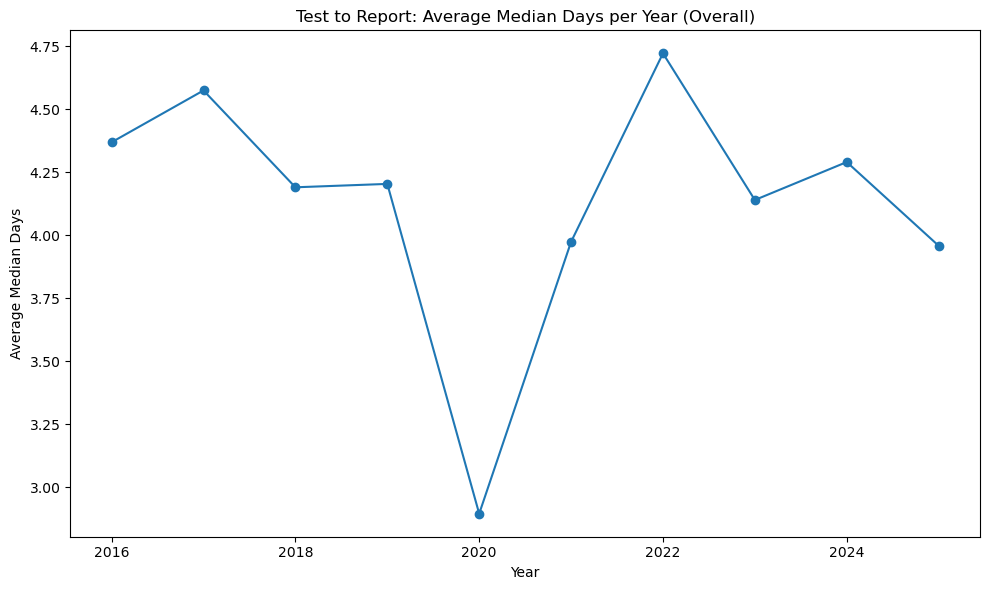

In [15]:
# %% Yearly averages (overall) — line chart
OUT_PNG_YEARLY_OVERALL = OUT_DIR / "test_to_report_yearly_overall.png"
OUT_CSV_YEARLY_OVERALL = OUT_DIR / "test_to_report_yearly_overall.csv"

rep_filt[date_col] = pd.to_datetime(rep_filt[date_col], errors="coerce", dayfirst=True)

yearly_overall = (
    rep_filt
      .dropna(subset=[date_col, val_col])
      .assign(year=lambda d: d[date_col].dt.year)
      .dropna(subset=["year"])
      .groupby("year", as_index=False)[val_col].mean()
      .rename(columns={val_col: "median_days"})
      .sort_values("year")
)

yearly_overall.to_csv(OUT_CSV_YEARLY_OVERALL, index=False)

plt.figure(figsize=(10, 6))
plt.plot(yearly_overall["year"], yearly_overall["median_days"], marker="o")
plt.title("Test to Report: Average Median Days per Year (Overall)")
plt.xlabel("Year")
plt.ylabel("Average Median Days")
plt.tight_layout()
plt.savefig(OUT_PNG_YEARLY_OVERALL, dpi=200, bbox_inches="tight")
plt.show()


### Test to Report Trend Monthly

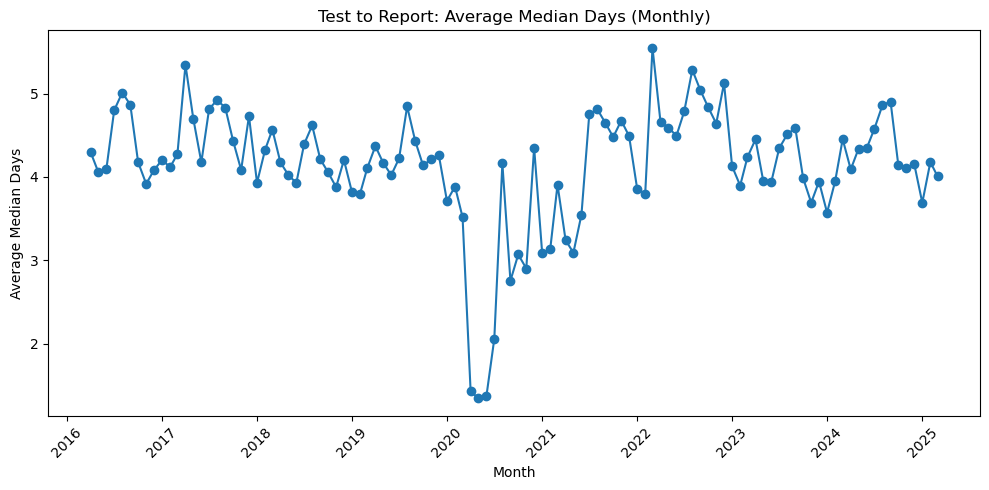

Monthly CSV: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\test_to_report_monthly_averages.csv
Monthly figure: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\test_to_report_monthly_avg.png


In [10]:
# %% Monthly averages (overall) and plot
tidy = (
    rep_filt
      .loc[:, [date_col, val_col]]
      .rename(columns={date_col: "date", val_col: "median_days"})
      .dropna(subset=["date","median_days"])
      .sort_values("date")
)

monthly = (
    tidy.assign(year_month=tidy["date"].dt.to_period("M").dt.to_timestamp())
        .groupby("year_month", as_index=False)["median_days"]
        .mean()
)

monthly.to_csv(OUT_CSV_MONTHLY, index=False)

plt.figure(figsize=(10,5))
plt.plot(monthly["year_month"], monthly["median_days"], marker="o")
plt.title("Test to Report: Average Median Days (Monthly)")
plt.xlabel("Month")
plt.ylabel("Average Median Days")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_PNG_MONTHLY, dpi=200, bbox_inches="tight")
plt.show()

print("Monthly CSV:", OUT_CSV_MONTHLY.resolve())
print("Monthly figure:", OUT_PNG_MONTHLY.resolve())


### Test to Report Trend Monthly NHS vs Private

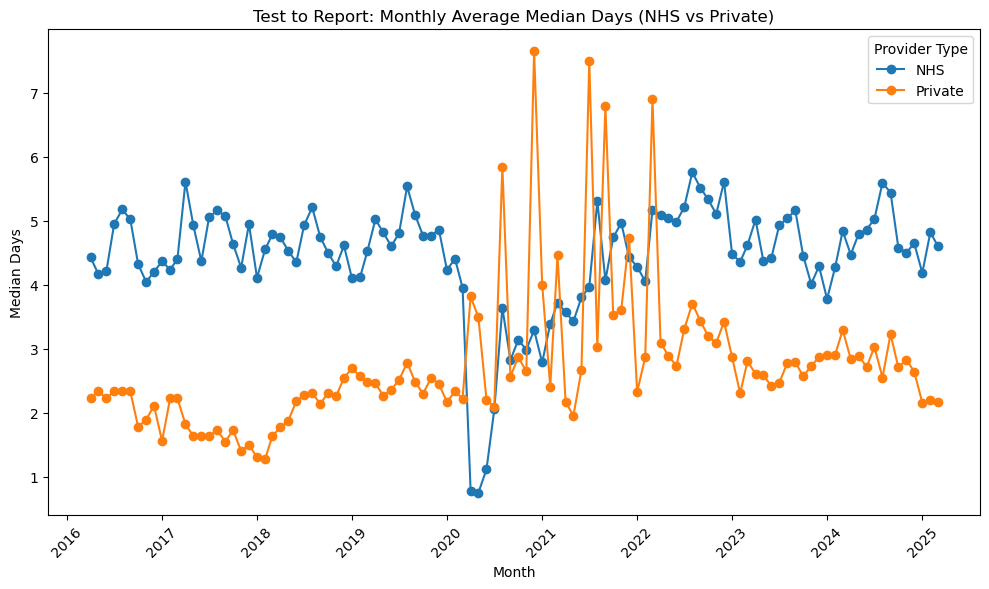

Monthly NHS vs Private figure: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\test_to_report_monthly_nhs_vs_private.png


In [11]:
# %% Monthly averages by provider type (NHS vs Private) and plot
rep_filt["year_month"] = rep_filt[date_col].dt.to_period("M").dt.to_timestamp()
monthly_types = (
    rep_filt.dropna(subset=[date_col, val_col, "provider_type"])
            .groupby(["year_month","provider_type"])[val_col]
            .mean()
            .reset_index()
            .rename(columns={val_col: "median_days"})
            .sort_values(["year_month","provider_type"])
)

plt.figure(figsize=(10,6))
for ptype in ["NHS", "Private", "Unknown"]:
    sub = monthly_types[monthly_types["provider_type"] == ptype]
    if sub.empty:
        continue
    plt.plot(sub["year_month"], sub["median_days"], marker="o", label=ptype)

plt.title("Test to Report: Monthly Average Median Days (NHS vs Private)")
plt.xlabel("Month")
plt.ylabel("Median Days")
plt.xticks(rotation=45)
plt.legend(title="Provider Type")
plt.tight_layout()
plt.savefig(OUT_PNG_MONTHLY_TYPES, dpi=200, bbox_inches="tight")
plt.show()

print("Monthly NHS vs Private figure:", OUT_PNG_MONTHLY_TYPES.resolve())


### Test to Report Trend Yearly NHS vs Private

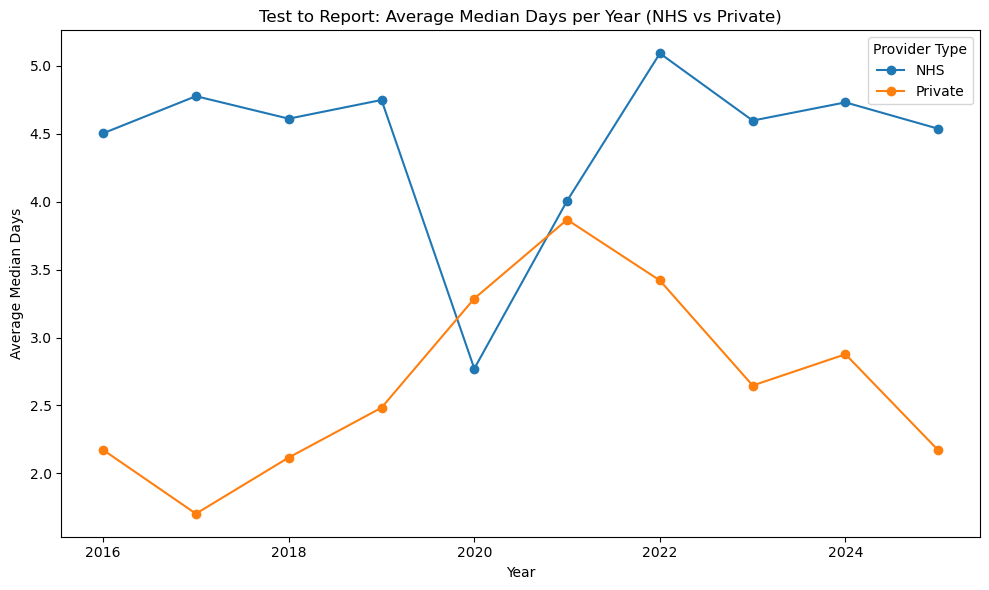

Yearly CSV: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\test_to_report_yearly_averages.csv
Yearly figure: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\test_to_report_yearly_nhs_vs_private.png


In [12]:
# %% Yearly averages by provider type and plot
rep_filt["year"] = rep_filt[date_col].dt.year

yearly = (
    rep_filt.dropna(subset=[date_col, val_col, "year", "provider_type"])
            .groupby(["year","provider_type"])[val_col]
            .mean()
            .reset_index()
            .rename(columns={val_col: "median_days"})
            .sort_values(["year","provider_type"])
)

yearly.to_csv(OUT_CSV_YEARLY, index=False)

plt.figure(figsize=(10,6))
for ptype in ["NHS", "Private", "Unknown"]:
    sub = yearly[yearly["provider_type"] == ptype]
    if sub.empty:
        continue
    plt.plot(sub["year"], sub["median_days"], marker="o", label=ptype)

plt.title("Test to Report: Average Median Days per Year (NHS vs Private)")
plt.xlabel("Year")
plt.ylabel("Average Median Days")
plt.legend(title="Provider Type")
plt.tight_layout()
plt.savefig(OUT_PNG_YEARLY_TYPES, dpi=200, bbox_inches="tight")
plt.show()

print("Yearly CSV:", OUT_CSV_YEARLY.resolve())
print("Yearly figure:", OUT_PNG_YEARLY_TYPES.resolve())


### Test to Report Number per Region

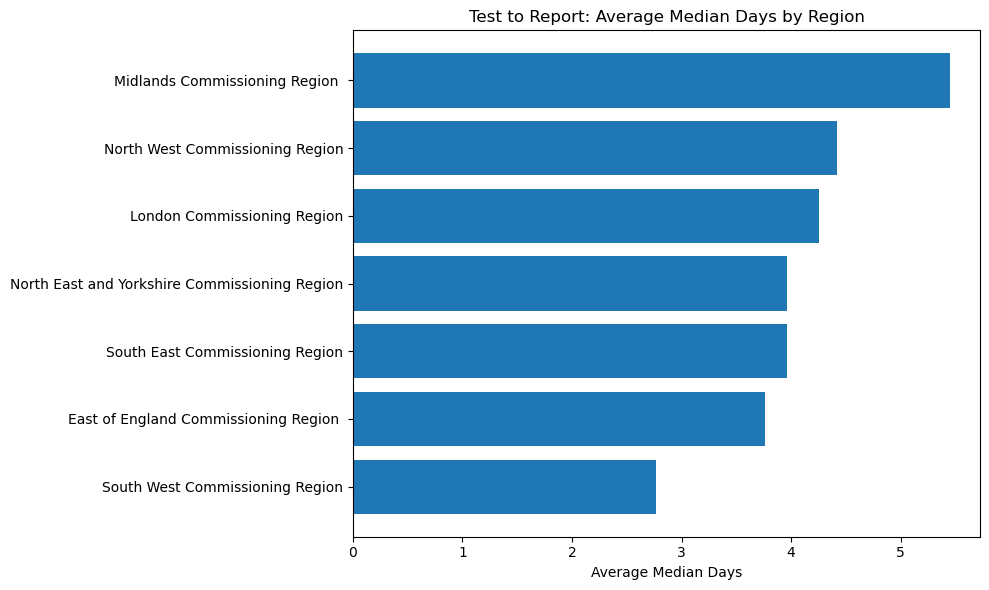

Region averages CSV: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\test_to_report_region_names_avg.csv
Region averages figure: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\outputs\test_to_report_region_names_avg.png


In [13]:
# %% Region average using provider -> region name fill (optional) and plot
# builds a provider->region mapping to fill missing region names, then averages per region
region_name_col = region_name_col or ("regionname" if "regionname" in rep_filt.columns else None)
region_code_col = region_code_col or ("region" if "region" in rep_filt.columns else None)

if region_name_col is None and region_code_col is not None:
    region_name_col = "regionname"
    rep_filt[region_name_col] = rep_filt[region_code_col].copy()
elif region_name_col is None and region_code_col is None:
    region_name_col = None  # skip if no region fields exist

if region_name_col is not None and prov_col is not None:
    provider_to_region = (
        rep_filt.dropna(subset=[region_name_col])
               .groupby(prov_col)[region_name_col]
               .agg(lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])
               .to_dict()
    )

    rep_filt[region_name_col] = rep_filt.apply(
        lambda r: provider_to_region.get(r[prov_col], r[region_name_col]),
        axis=1
    )

    avg_region = (
        rep_filt.groupby(region_name_col)[val_col]
                .mean()
                .reset_index()
                .rename(columns={val_col: "average_median_days"})
                .sort_values("average_median_days")
                .reset_index(drop=True)
    )

    avg_region.to_csv(OUT_CSV_REGION, index=False)

    plt.figure(figsize=(10,6))
    plt.barh(avg_region[region_name_col].astype(str), avg_region["average_median_days"])
    plt.xlabel("Average Median Days")
    plt.title("Test to Report: Average Median Days by Region")
    plt.tight_layout()
    plt.savefig(OUT_PNG_REGION, dpi=200, bbox_inches="tight")
    plt.show()

    print("Region averages CSV:", OUT_CSV_REGION.resolve())
    print("Region averages figure:", OUT_PNG_REGION.resolve())
else:
    print("Region averages skipped (no region columns found).")


In [14]:
# %% Diagnostics (optional)
print("Detected date column:", date_col)
print("Detected value column:", val_col)
print("Provider column:", prov_col)
print("Rows:", len(rep))
print(rep[[date_col, val_col, prov_col, "provider_type"]].head(10))


Detected date column: date
Detected value column: median_days_test_to_report
Provider column: provider_name
Rows: 19460
        date  median_days_test_to_report  \
0 2016-04-01                         4.0   
1 2016-05-01                         2.0   
2 2016-06-01                         3.0   
3 2016-07-01                         3.0   
4 2016-08-01                         3.0   
5 2016-09-01                         5.0   
6 2016-10-01                         3.0   
7 2016-11-01                         2.0   
8 2016-12-01                         3.0   
9 2017-01-01                         4.0   

                                      provider_name provider_type  
0  Aintree University Hospital NHS Foundation Trust           NHS  
1  Aintree University Hospital NHS Foundation Trust           NHS  
2  Aintree University Hospital NHS Foundation Trust           NHS  
3  Aintree University Hospital NHS Foundation Trust           NHS  
4  Aintree University Hospital NHS Foundation Trust    